/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.0045 - val_loss: 1.0943e-04 - learning_rate: 5.0000e-04
Epoch 2/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.3673e-04 - val_loss: 5.3887e-05 - learning_rate: 5.0000e-04
Epoch 3/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.0161e-04 - val_loss: 3.6443e-05 - learning_rate: 5.0000e-04
Epoch 4/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.6336e-05 - val_loss: 4.7945e-05 - learning_rate: 5.0000e-04
Epoch 5/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8.8073e-05 - val_loss: 2.5447e-05 - learning_rate: 5.0000e-04
Epoch 6/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.5691e-05 - val_loss: 2.6451e-05 - learning_rate: 5.0000e-04
Epoch 7/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 6.2042e-05 - val_loss: 3.0336e-05 - learning_rate: 2.5000e-04
Epoch 8/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4.8408e-05 - val_loss: 4.5593e-05 - learning_rate: 2.5000e-04
Epoch 9/70
136/136 

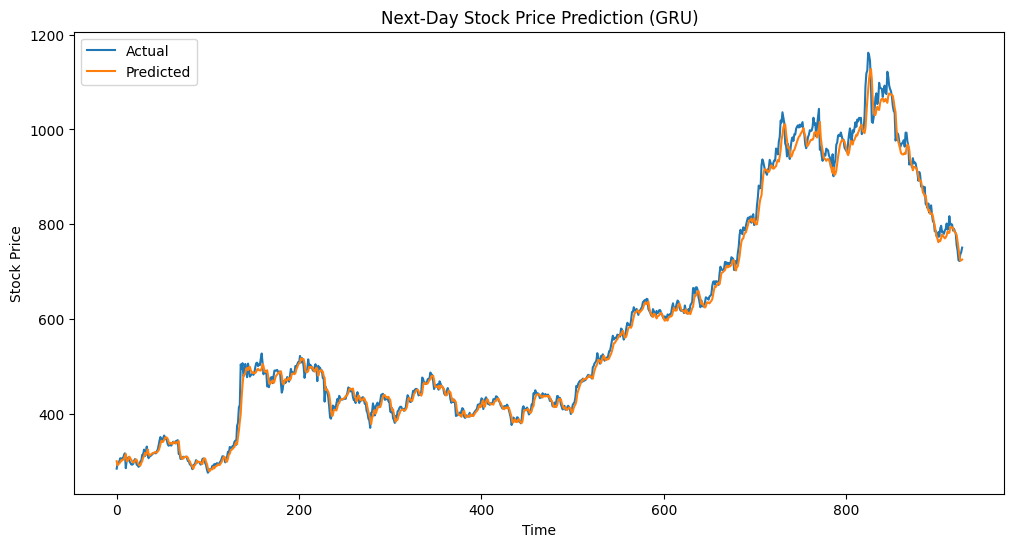

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout,Attention, LayerNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
# import pandas_ta as ta

# Load the dataset
data = pd.read_csv("https://raw.githubusercontent.com/ranjithkumar5807/stock-prediction/refs/heads/main/technical%20indicators/TATAMOTORS.NS_indicators.csv")

# Selecting important features
selected_features = ['close', 'high', 'low', 'open', 'volume', 'MACD', 'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower',"SMA_13","SMA_21"]

# Adding Moving Averages
# data['SMA_10'] = data['close'].rolling(window=10).mean()
# data['SMA_21'] = data['close'].rolling(window=21).mean()
# data['EMA_5'] = ta.ema(data['close'], length=5)
# data['EMA_8'] = ta.ema(data['close'], length=8)
# data['EMA_13'] = ta.ema(data['close'], length=13)
data = data[selected_features].dropna()


# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Function to create sequences for next-day prediction
def create_sequences(data, sequence_length=20):
    X, y = [], []
    for i in range(len(data) - sequence_length - 1):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # Predicting 'close' price
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

# Train-Test-Validation Split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Build GRU Model
model = Sequential()
model.add(Bidirectional(GRU(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(512, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile Model
optimizer = AdamW(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=Huber(delta=1.0))  # Using Huber Loss

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the Model
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr])

# Predictions
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Evaluate Performance
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
r2 = r2_score(y_test_actual, y_pred_actual)
rmse_percentage = (rmse / np.mean(y_test_actual)) * 100

print(f'GRU Next-Day Prediction Metrics:')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')
print(f'MAPE: {mape}%')
print(f'RMSE Percentage: {rmse_percentage}%')

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.title('Next-Day TATA MOTORS Stock Price Prediction (GRU)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
import json
import joblib
from tensorflow.keras.models import load_model

# Save Model
model.save('GRU_model.h5')

# Save Scaler
joblib.dump(scaler, 'scaler.pkl')

# Save Features List
# features = ['close', 'high', 'low', 'open', 'volume', 'MACD', 'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower', "SMA_10", "SMA_21"]
with open('features.json', 'w') as f:
    json.dump(selected_features, f)

# Save Training History
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

# Save Performance Metrics
metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape,
    "RMSE_Percentage": rmse_percentage
}
with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f)

with open('sequence_length.txt','w') as f:
  json.dump(sequence_length,f)
